In [1]:
# Standard libraries
import os
import random

# Third-party libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch import utils
from torch.utils.data import DataLoader, Dataset, random_split

# torchvision libraries
from torchvision import datasets, models, transforms
from torchvision.models import EfficientNet_B0_Weights, ResNet18_Weights


In [2]:

print("PyTorch version:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Nombre del GPU:", torch.cuda.get_device_name(0))
else:
    print("No se detectó GPU.")



PyTorch version: 2.5.1
CUDA disponible: True
Nombre del GPU: NVIDIA GeForce RTX 4060 Laptop GPU


# Exploring Dataset

In [ ]:

BATCH_SIZE = 128
IMG_SIZE = 128

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5)

])

class GarbageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
     
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir) # each folder in root_dir is a class
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for cls in self.classes:
            cls_folder = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_folder):
                self.image_paths.append(os.path.join(cls_folder, img_name))
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    

import matplotlib.pyplot as plt
import numpy as np

def show_sample_per_class(dataset):
    class_seen = set() 
    samples = []

    for image, label in dataset:
        if label not in class_seen:
            samples.append((image, label))
            class_seen.add(label)
        if len(class_seen) == len(dataset.classes):  
            break

    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(samples):
        image_np = image.permute(1, 2, 0).numpy().clip(0, 1)
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(image_np)
        plt.title(dataset.classes[label])
        plt.axis("off")
    
    plt.show()


In [ ]:

dataset = GarbageDataset(root_dir="Garbage Classification", transform=data_transform)

print("Dataset size:", len(dataset))
print("Number of classes:", len(dataset.classes))
print("Classes:", dataset.classes)
print("Class to index mapping:", dataset.class_to_idx)


train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  


train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("\n")
print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))



Dataset size: 4650
Number of classes: 6
Classes: ['battery', 'glass', 'metal', 'organic', 'paper', 'plastic']
Class to index mapping: {'battery': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5}


Training set size: 3255
Validation set size: 697
Test set size: 698


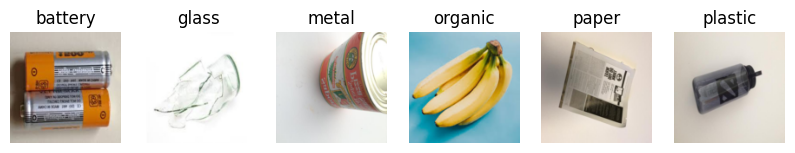

In [ ]:
show_sample_per_class(dataset)

# Pre-Task Training

Starting training...
Epoch 1/20, Training Loss: 0.6369, Training Accuracy: 0.7871
Epoch 1/20, Validation Loss: 0.4097, Validation Accuracy: 0.8666
Best model saved!
Epoch 2/20, Training Loss: 0.1568, Training Accuracy: 0.9475
Epoch 2/20, Validation Loss: 0.2056, Validation Accuracy: 0.9369
Best model saved!
Epoch 3/20, Training Loss: 0.0809, Training Accuracy: 0.9696
Epoch 3/20, Validation Loss: 0.2284, Validation Accuracy: 0.9498
Best model saved!
Epoch 4/20, Training Loss: 0.0861, Training Accuracy: 0.9748
Epoch 4/20, Validation Loss: 0.2224, Validation Accuracy: 0.9369
Epoch 5/20, Training Loss: 0.0730, Training Accuracy: 0.9751
Epoch 5/20, Validation Loss: 0.1810, Validation Accuracy: 0.9555
Best model saved!
Epoch 6/20, Training Loss: 0.0622, Training Accuracy: 0.9810
Epoch 6/20, Validation Loss: 0.1770, Validation Accuracy: 0.9570
Best model saved!
Epoch 7/20, Training Loss: 0.0422, Training Accuracy: 0.9859
Epoch 7/20, Validation Loss: 0.1938, Validation Accuracy: 0.9484
Epoch 8

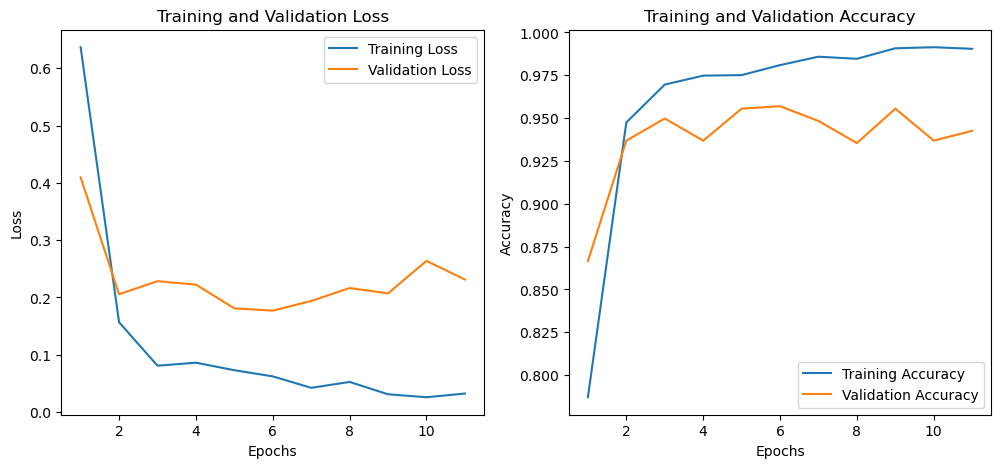

In [ ]:
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze the initial layers
for param in model.features[:3].parameters(): 
    param.requires_grad = False


num_classes = len(dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  
    nn.Linear(model.classifier[1].in_features, num_classes)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

early_stop_patience = 5
best_val_acc = 0.0
patience_counter = 0

print("Starting training...")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    global best_val_acc, patience_counter

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'baseline.pth')
            print("Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()


# Basline Testing

In [5]:
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_classes = 6
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model.load_state_dict(torch.load('baseline.pth'))

<All keys matched successfully>

Test Loss: 0.1657
Test Accuracy: 94.27%


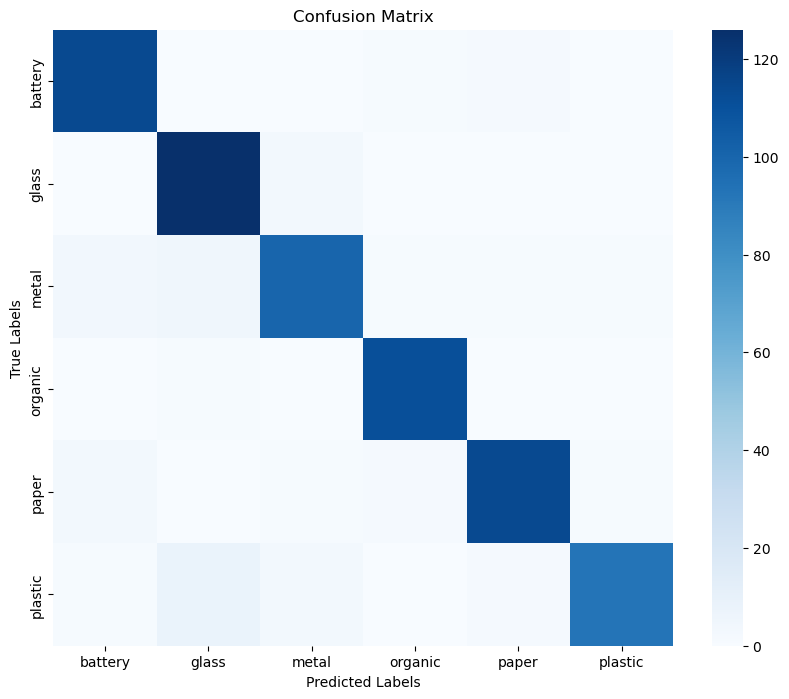

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the model to evaluation mode
model.eval()

test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

# Disable gradient calculation for evaluation
with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions and labels for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute the average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
num_classes = len(dataset.classes)  # Adjust according to your dataset
class_names = dataset.classes  # Replace with your actual class names if available

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


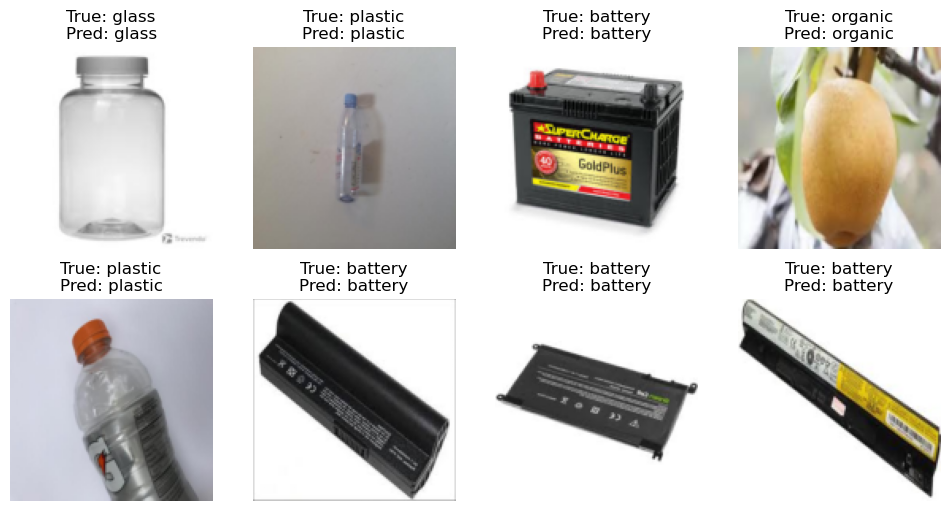

In [52]:
import matplotlib.pyplot as plt
import random

model.eval()

random_indices = random.sample(range(len(test_set)), BATCH_SIZE)
images, labels = zip(*[test_set[i] for i in random_indices]) 

images = torch.stack(images)
labels = torch.tensor(labels)

images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)


num_samples = min(8, len(images)) 
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 4, i + 1)
    image_np = images[i].cpu().permute(1, 2, 0).numpy().clip(0, 1)
    plt.imshow(image_np)
    plt.title(f"True: {dataset.classes[labels[i].item()]}\nPred: {dataset.classes[predictions[i].item()]}")
    plt.axis("off")

plt.show()


# Fine-tuning

In [ ]:
import os
from PIL import Image
import pillow_heif

# Register HEIF opener
pillow_heif.register_heif_opener()

folder = "custom_dataset"

def convert_heic_to_jpeg(heic_path, jpeg_path):
    image = Image.open(heic_path)
    image = image.convert("RGB")  # Convert to RGB to save as JPEG
    image.save(jpeg_path, "JPEG")

# Iterate through dataset and convert HEIC to JPEG
for class_name in os.listdir(folder):
    class_folder = os.path.join(folder, class_name)
    if not os.path.isdir(class_folder):
        continue
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        if img_path.lower().endswith(".heic"):
            jpeg_path = img_path.replace(".HEIC", ".jpeg")
            convert_heic_to_jpeg(img_path, jpeg_path)
            os.remove(img_path)
            print(f"Converted {img_path} to {jpeg_path}")

# remove all HEIC files

for class_name in os.listdir(folder):
    class_folder = os.path.join(folder, class_name)
    if not os.path.isdir(class_folder):
        continue
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        if img_path.lower().endswith(".heic"):
            os.remove(img_path)
            print(f"Removed {img_path}")


In [10]:

print("PyTorch version:", torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Nombre del GPU:", torch.cuda.get_device_name(0))
else:
    print("No se detectó GPU.")



PyTorch version: 2.5.1
CUDA disponible: True
Nombre del GPU: NVIDIA GeForce RTX 4060 Laptop GPU


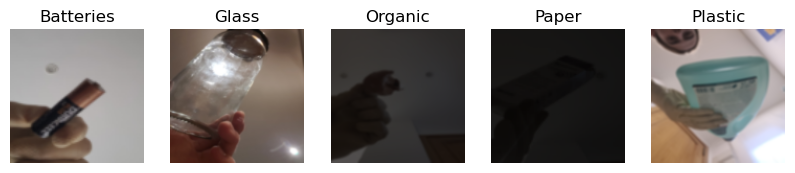

Custom dataset size: 896
Number of classes: 5
Classes: ['Batteries', 'Glass', 'Organic', 'Paper', 'Plastic']
Class to index mapping: {'Batteries': 0, 'Glass': 1, 'Organic': 2, 'Paper': 3, 'Plastic': 4}


In [18]:
from torchvision import transforms

IMG_SIZE = 128

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomChoice([
        transforms.Lambda(lambda x: transforms.functional.rotate(x, angle))
        for angle in [0, 90, 180, 270]
    ]),
    transforms.RandomApply([
        transforms.CenterCrop(90)
    ], p=0.5),  
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3)
    ], p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=(0.1,1)),
    ], p=0.5),

    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


custom_dataset = GarbageDataset(root_dir="custom_dataset", transform=data_transform)
show_sample_per_class(custom_dataset)

print("Custom dataset size:", len(custom_dataset))
print("Number of classes:", len(custom_dataset.classes))
print("Classes:", custom_dataset.classes)
print("Class to index mapping:", custom_dataset.class_to_idx)

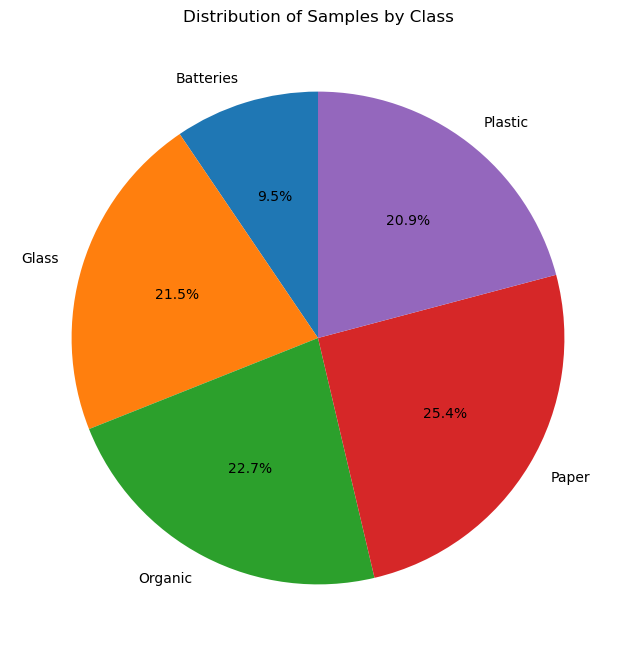

In [19]:
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(custom_dataset.labels)
class_labels = [custom_dataset.classes[i] for i in class_counts.keys()]
class_values = list(class_counts.values())

plt.figure(figsize=(8, 8))
plt.pie(class_values, labels=class_labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Samples by Class")
plt.show()


In [21]:
train_custom_data, val_custom_data = train_test_split(custom_dataset, test_size=0.15, random_state=42)

print("Custom dataset size:", len(custom_dataset))
print("Training set size:", len(train_custom_data))
print("Validation set size:", len(val_custom_data))

Custom dataset size: 896
Training set size: 761
Validation set size: 135


In [29]:
BATCH_SIZE = 64
train_custom_loader = DataLoader(train_custom_data, batch_size=BATCH_SIZE, shuffle=True)
val_custom_loader = DataLoader(val_custom_data, batch_size=BATCH_SIZE, shuffle=False)

#torch.save(train_custom_loader, "train_custom_loader.pth")
#torch.save(val_custom_loader, "val_custom_loader.pth")

Device: cuda
Starting training...
Epoch 1/150, Training Loss: 1.5480, Training Accuracy: 0.3206
Epoch 1/150, Validation Loss: 1.3091, Validation Accuracy: 0.5778
Best model saved!
Epoch 2/150, Training Loss: 1.2829, Training Accuracy: 0.5283
Epoch 2/150, Validation Loss: 1.1187, Validation Accuracy: 0.6889
Best model saved!
Epoch 3/150, Training Loss: 1.0868, Training Accuracy: 0.6399
Epoch 3/150, Validation Loss: 0.9721, Validation Accuracy: 0.6667
Epoch 4/150, Training Loss: 0.8952, Training Accuracy: 0.7267
Epoch 4/150, Validation Loss: 0.8533, Validation Accuracy: 0.6815
Epoch 5/150, Training Loss: 0.7684, Training Accuracy: 0.7779
Epoch 5/150, Validation Loss: 0.7631, Validation Accuracy: 0.7111
Best model saved!
Epoch 6/150, Training Loss: 0.6038, Training Accuracy: 0.8463
Epoch 6/150, Validation Loss: 0.6922, Validation Accuracy: 0.7481
Best model saved!
Epoch 7/150, Training Loss: 0.4747, Training Accuracy: 0.8686
Epoch 7/150, Validation Loss: 0.6301, Validation Accuracy: 0.777

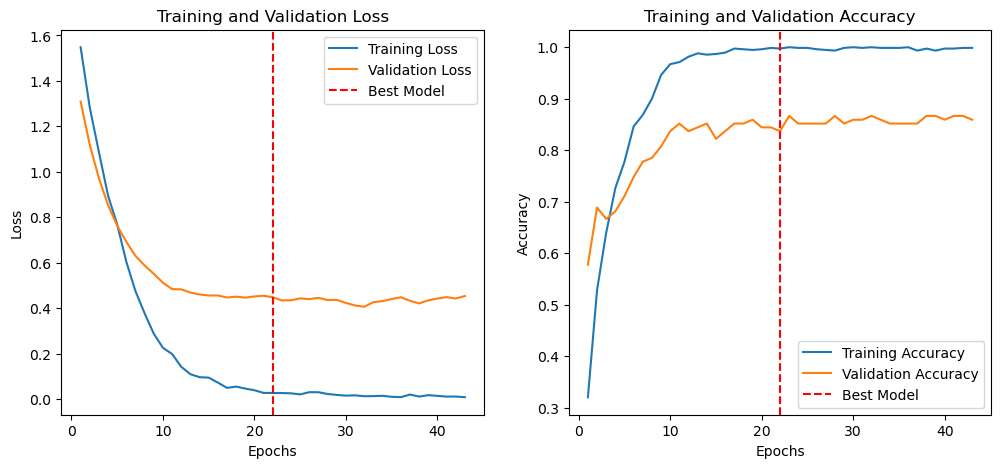

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  
    nn.Linear(model.classifier[1].in_features, 6)
)
model.load_state_dict(torch.load(r'C:\Users\User\OneDrive\Escritorio\AI Garbage Classification\AutoRecycle\Best Models\baseline.pth', weights_only=True))

num_classes = len(custom_dataset.classes)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  
    nn.Linear(model.classifier[1].in_features, num_classes)
)

for param in model.features[:4].parameters(): 
    param.requires_grad = False

model = model.to(device)
model.eval()
for layer in model.features[:4]:
    if isinstance(layer, nn.BatchNorm2d):
        layer.eval()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.0001, weight_decay=1e-4  # L2 regularization with weight decay
)

early_stop_patience = 20
best_val_acc = 0.0
patience_counter = 0

print("Starting training...")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    global best_val_acc, patience_counter

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'FinalTeacher.pth')
            print("Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

num_epochs = 150
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_custom_loader, val_custom_loader, criterion, optimizer, num_epochs=num_epochs
)

# Plot training and validation losses and accuracies
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
# line when the model was saved
plt.axvline(x=np.argmax(val_accuracies), color="red", linestyle="--", label="Best Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.axvline(x=np.argmax(val_accuracies), color="red", linestyle="--", label="Best Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()


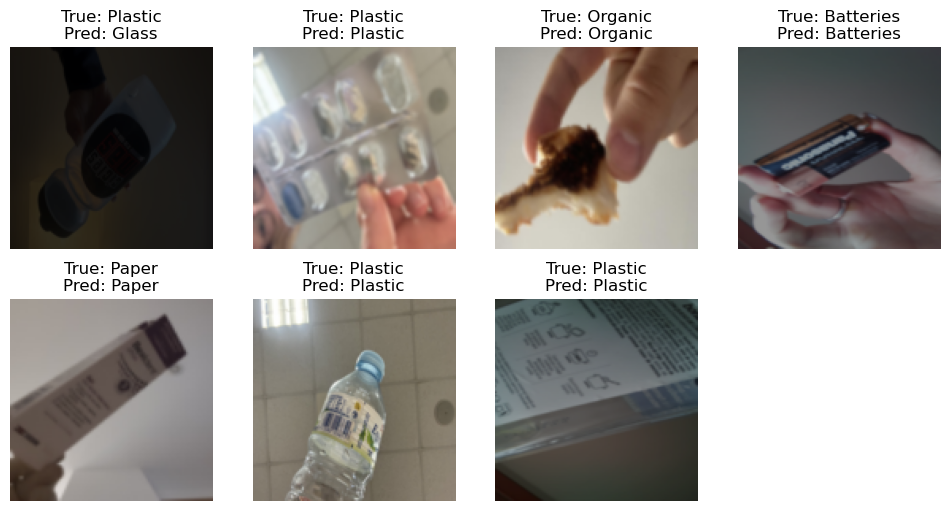

Test Loss: 0.4187
Test Accuracy: 86.67%


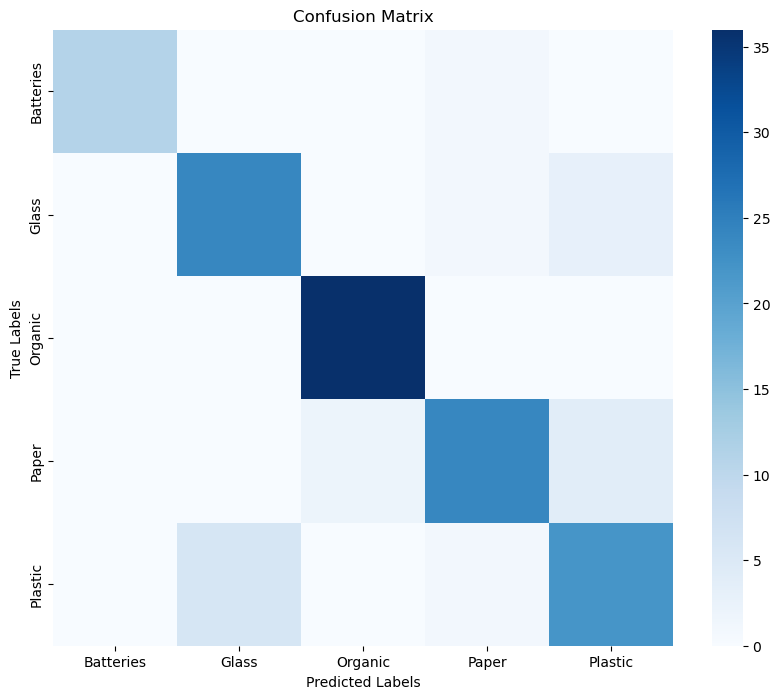

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.classifier = nn.Sequential(
    nn.Dropout(0.5),  
    nn.Linear(model.classifier[1].in_features, 5)
)

model.load_state_dict(torch.load('FinalTeacher.pth', weights_only=True))
model = model.to(device)

# Set the model to evaluation mode
model.eval()

test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

criterion = nn.CrossEntropyLoss()

# Disable gradient calculation for evaluation
with torch.no_grad():  
    for images, labels in val_custom_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        
        # Collect predictions and labels for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Plot the first batch of images in the validation set
        if total >= len(val_custom_loader.dataset):
            num_samples = min(8, len(images)) 
            plt.figure(figsize=(12, 6))
            for i in range(num_samples):
                plt.subplot(2, 4, i + 1)
                image_np = images[i].cpu().permute(1, 2, 0).numpy().clip(0, 1)
                plt.imshow(image_np)
                plt.title(f"True: {custom_dataset.classes[labels[i].item()]}\nPred: {custom_dataset.classes[predicted[i].item()]}")
                plt.axis("off")

            plt.show()

# Compute the average test loss and accuracy
test_loss /= len(val_custom_loader)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
num_classes = len(custom_dataset.classes)  # Adjust according to your dataset
class_names = custom_dataset.classes  # Replace with your actual class names if available

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


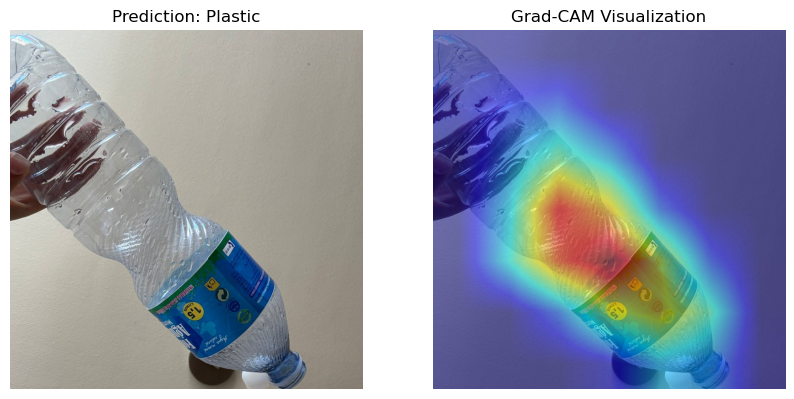

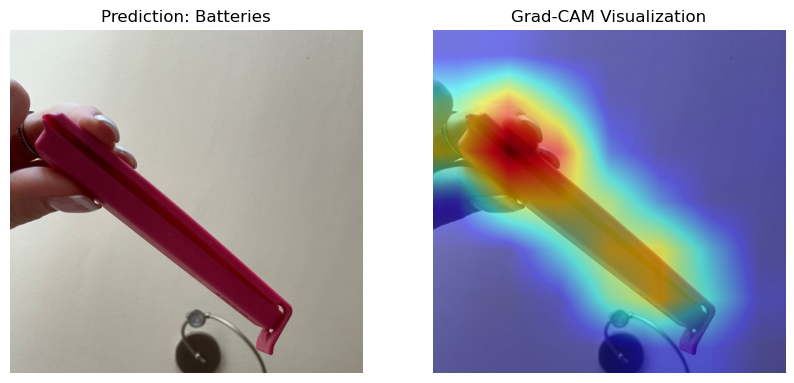

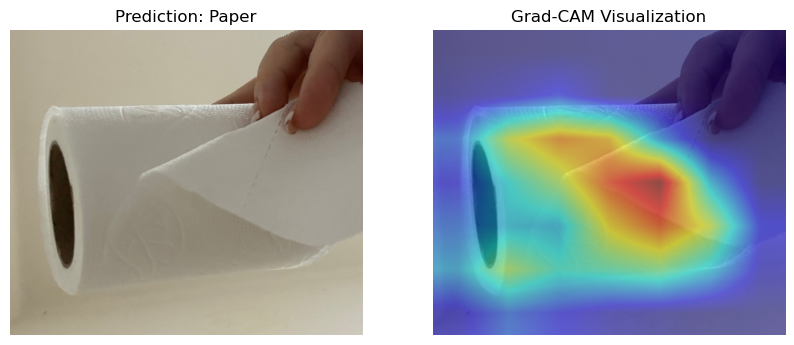

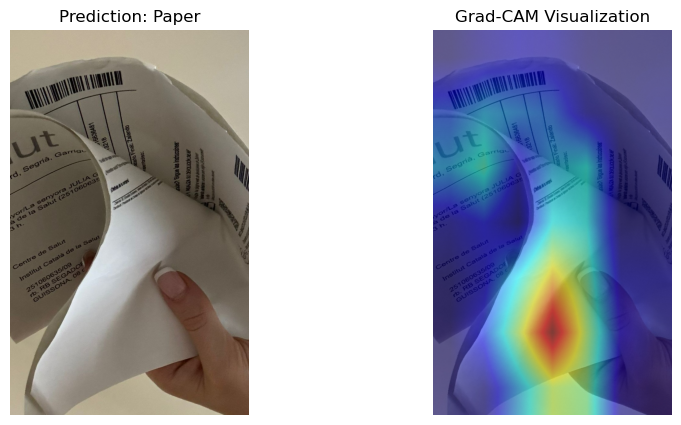

In [37]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
from torchvision import models, transforms
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt



# Load your model and adjust the final layer to match your number of classes
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier[1].in_features, 5)  # Adjust for 5 classes
)
model.load_state_dict(torch.load(r'C:\Users\User\OneDrive\Escritorio\AI Garbage Classification\AutoRecycle\Best Models\finetuned_v1.pth', weights_only=True))

model = model.to(device)
model.eval()


IMG_SIZE = 224
# Inference of an image

import os
from PIL import Image
import torch
import torch.nn as nn

folder = R"C:\Users\User\OneDrive\Escritorio\AI Garbage Classification\AutoRecycle\testing_images"
img_files = os.listdir(folder)

for img_file in img_files:
    img_path = os.path.join(folder, img_file)

    # Load and preprocess the image
    image = Image.open(img_path).convert("RGB")

    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(), 
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = data_transform(image).unsqueeze(0)
    input_tensor = image_tensor.to(device)
    model = model.to(device)

    # Make a prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, prediction = torch.max(output, 1)

    # print(f"Prediction: {custom_dataset.classes[prediction.item()]}")

    # Choose the last convolutional layer
    target_layers = [model.features[-1]]

    # Use Grad-CAM or any other CAM method
    with GradCAM(model=model, target_layers=target_layers) as cam:

        targets = [ClassifierOutputTarget(prediction.item())] 
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        # Convert grayscale CAM to an overlay on the original image
        rgb_img = np.array(image) / 255.0

        grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))
        visualization = show_cam_on_image(rgb_img, grayscale_cam_resized, use_rgb=True)

        pred2class = {'Batteries': 0, 'Glass': 1, 'Organic': 2, 'Paper': 3, 'Plastic': 4}
        class2pred = {v: k for k, v in pred2class.items()}

        # Plot both the input image and the Grad-CAM visualization side by side
        plt.figure(figsize=(10, 5))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(rgb_img)
        plt.title("Prediction: " + class2pred[prediction.item()])
        #plt.title("Prediction: " + custom_dataset.classes[prediction.item()])
        plt.axis("off")
        
        # Grad-CAM visualization
        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title("Grad-CAM Visualization")
        plt.axis("off")
        
        
        plt.show()


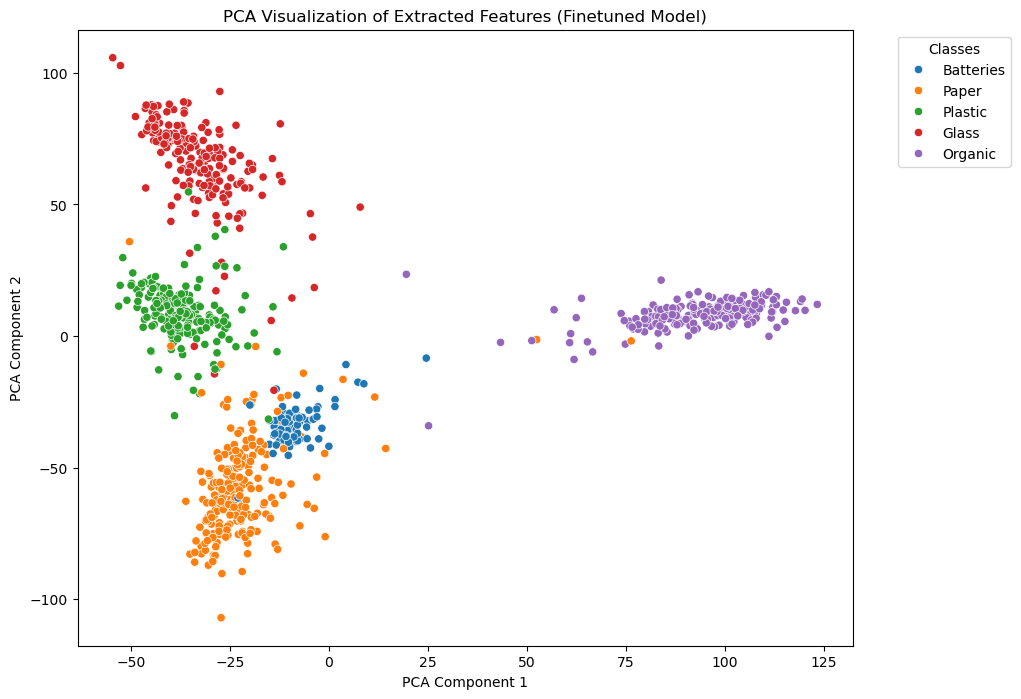

In [39]:
import torch
from sklearn.decomposition import PCA  # Import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the model to evaluation mode

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.5),  
    nn.Linear(model.classifier[1].in_features, 5)
)
model.load_state_dict(torch.load('FinalTeacher.pth', weights_only=True))
model = model.to(device)
model.eval()

# Lists to store extracted features and their corresponding labels
features = []
labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for loader in [train_custom_loader, val_custom_loader]:
        for images, lbls in loader:
            images = images.to(device)
            lbls = lbls.to(device)
            
            # Forward pass until the layer before classification to extract features
            outputs = model.features(images)  # Change this depending on the model architecture
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features if needed

            features.append(outputs.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

# Concatenate all features and labels into single arrays
features = np.concatenate(features, axis=0)
labels = np.array(labels)

# Reduce dimensions using PCA
pca = PCA(n_components=2, random_state=42)
features_2d = pca.fit_transform(features)

# Plot the PCA features
labels = [custom_dataset.classes[label] for label in labels]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette="tab10")
plt.title("PCA Visualization of Extracted Features (Finetuned Model)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



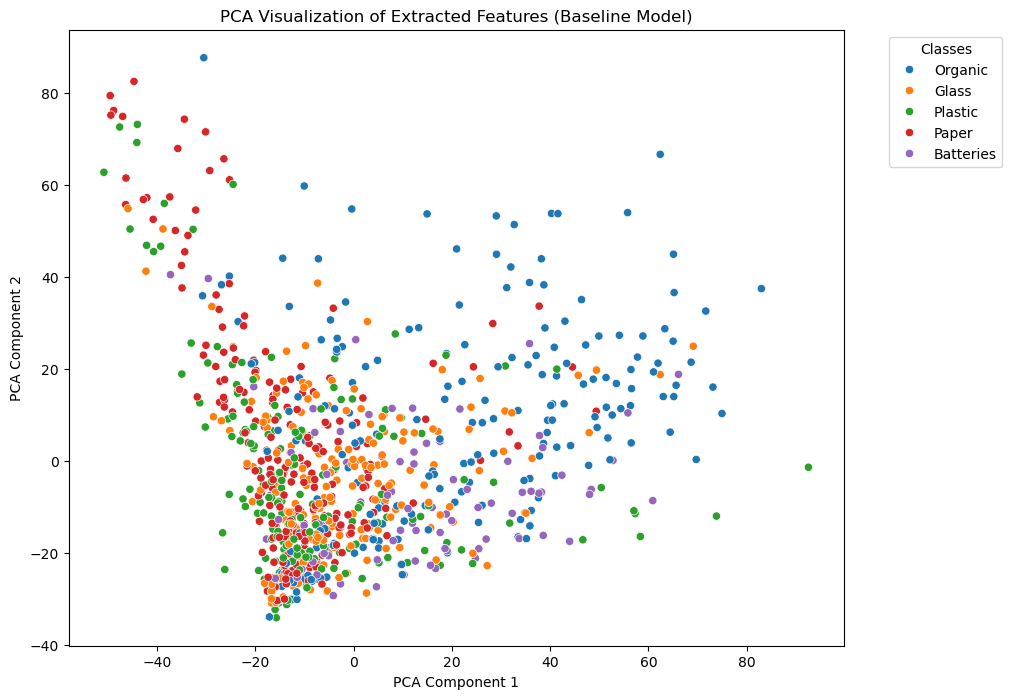

In [41]:
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),  
    nn.Linear(model.classifier[1].in_features, 6)
)
model.load_state_dict(torch.load(r'C:\Users\User\OneDrive\Escritorio\AI Garbage Classification\AutoRecycle\Best Models\baseline.pth', weights_only=True))

import torch
# import pca
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the model to evaluation mode
model = model.to(device)
model.eval()

# Lists to store extracted features and their corresponding labels
features = []
labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for loader in [train_custom_loader, val_custom_loader]:
        for images, lbls in loader:
            images = images.to(device)
            lbls = lbls.to(device)
            
            # Forward pass until the layer before classification to extract features
            outputs = model.features(images)  # Change this depending on the model architecture
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features if needed

            features.append(outputs.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

# Concatenate all features and labels into single arrays
features = np.concatenate(features, axis=0)
labels = np.array(labels)

# Reduce dimensions using PCA
pca = PCA(n_components=2, random_state=42)
features_2d = pca.fit_transform(features)

# Plot the PCA features
labels = [custom_dataset.classes[label] for label in labels]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette="tab10")
plt.title("PCA Visualization of Extracted Features (Baseline Model)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Knowledge Distillation

In [66]:
train_custom_loader = torch.load("train_custom_loader.pth", weights_only=False)
val_custom_loader = torch.load("val_custom_loader.pth", weights_only=False)

Epoch 1/150, Training Loss: 1.0283, Training Accuracy: 0.4363
Epoch 1/150, Validation Loss: 1.2886, Validation Accuracy: 0.5259
Best student model saved!
Epoch 2/150, Training Loss: 0.5099, Training Accuracy: 0.8528
Epoch 2/150, Validation Loss: 0.8370, Validation Accuracy: 0.6963
Best student model saved!
Epoch 3/150, Training Loss: 0.2621, Training Accuracy: 0.9251
Epoch 3/150, Validation Loss: 0.6038, Validation Accuracy: 0.7778
Best student model saved!
Epoch 4/150, Training Loss: 0.1209, Training Accuracy: 0.9790
Epoch 4/150, Validation Loss: 0.4836, Validation Accuracy: 0.8074
Best student model saved!
Epoch 5/150, Training Loss: 0.0617, Training Accuracy: 0.9934
Epoch 5/150, Validation Loss: 0.4636, Validation Accuracy: 0.8074
Epoch 6/150, Training Loss: 0.0337, Training Accuracy: 1.0000
Epoch 6/150, Validation Loss: 0.4783, Validation Accuracy: 0.8074
Epoch 7/150, Training Loss: 0.0189, Training Accuracy: 1.0000
Epoch 7/150, Validation Loss: 0.4969, Validation Accuracy: 0.8074


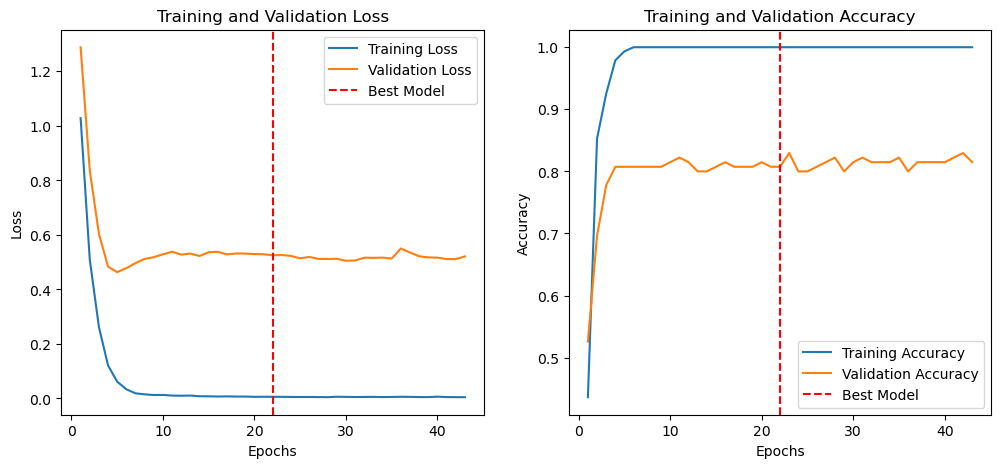

In [43]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import EfficientNet_B0_Weights

num_classes = 5


# Load the teacher model
teacher = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
teacher.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(teacher.classifier[1].in_features, num_classes)
)
teacher.load_state_dict(torch.load('FinalTeacher.pth', weights_only=True))

# Load the student model
student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
student.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(student.classifier[1].in_features, 5)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   

def distillation_loss(student_logits, teacher_logits, temperature):
    # Computes the Kullback-Leibler divergence between teacher and student logits
    return F.kl_div(
        F.log_softmax(student_logits / temperature, dim=1),
        F.softmax(teacher_logits / temperature, dim=1),
        reduction="batchmean"
    )

def train_distilled_model(student, teacher, train_loader, val_loader, optimizer, alpha=0.5, temperature=5, num_epochs=10):
    student = student.to(device)
    teacher = teacher.to(device)
    teacher.eval()  # Freeze teacher model

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    global best_val_acc, patience_counter

    for epoch in range(num_epochs):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Get outputs from both teacher and student models
            with torch.no_grad():
                teacher_outputs = teacher(images)
            student_outputs = student(images)

            # Compute the task loss and distillation loss
            task_loss = F.cross_entropy(student_outputs, labels)
            distill_loss = distillation_loss(student_outputs, teacher_outputs, temperature)
            loss = alpha * distill_loss + (1 - alpha) * task_loss

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(student_outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation phase
        student.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = student(images)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save(student.state_dict(), 'FinalStudent.pth')
            print("Best student model saved!")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    # Plot training and validation losses and accuracies
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.axvline(x=np.argmax(val_accuracies), color="red", linestyle="--", label="Best Model")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.axvline(x=np.argmax(val_accuracies), color="red", linestyle="--", label="Best Model")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

best_val_acc = 0.0
patience_counter = 0
early_stop_patience = 20

num_epochs = 150
alpha = 0.3
temperature = 5

optimizer = optim.Adam(student.parameters(), lr=0.0001)

# Call the training function with knowledge distillation
train_losses, val_losses, train_accuracies, val_accuracies = train_distilled_model(
    student, teacher, train_custom_loader, val_custom_loader, optimizer, alpha=alpha, temperature=temperature, num_epochs=num_epochs
)


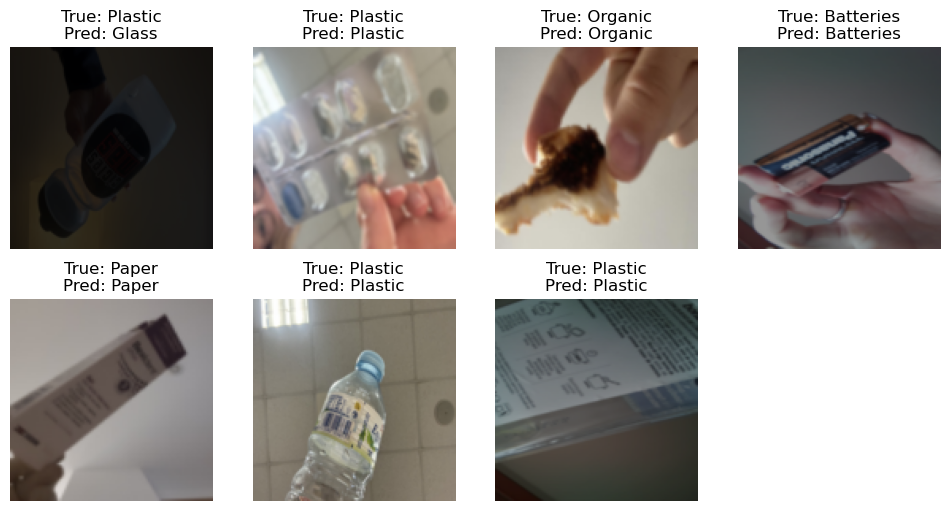

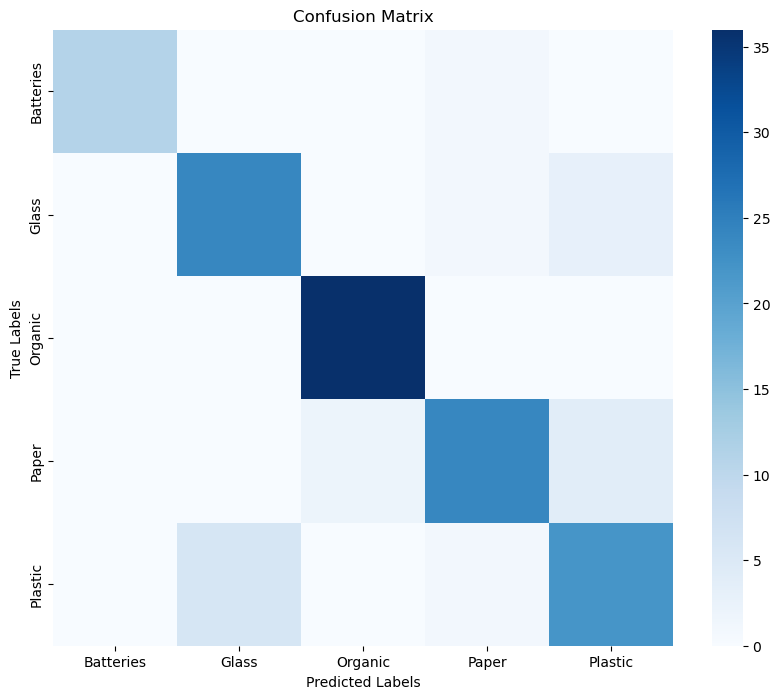

Teacher Model Validation Accuracy: 86.67%


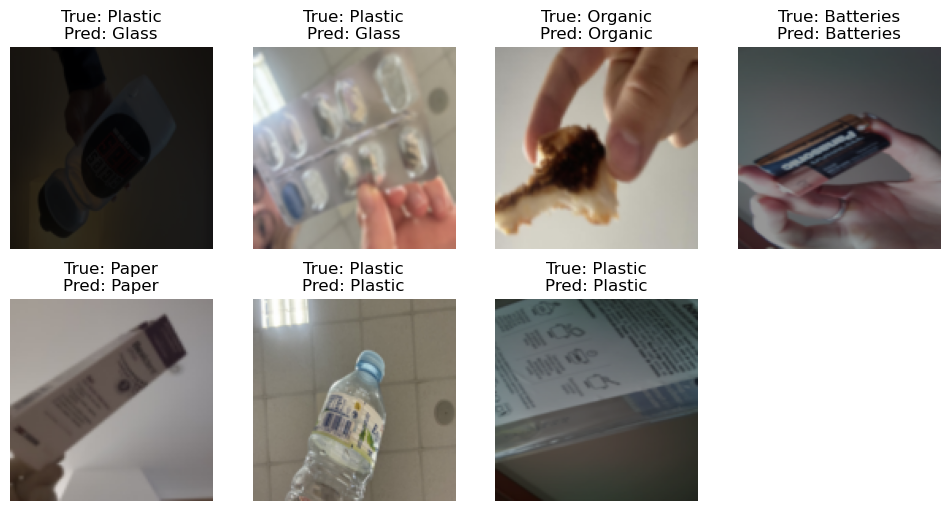

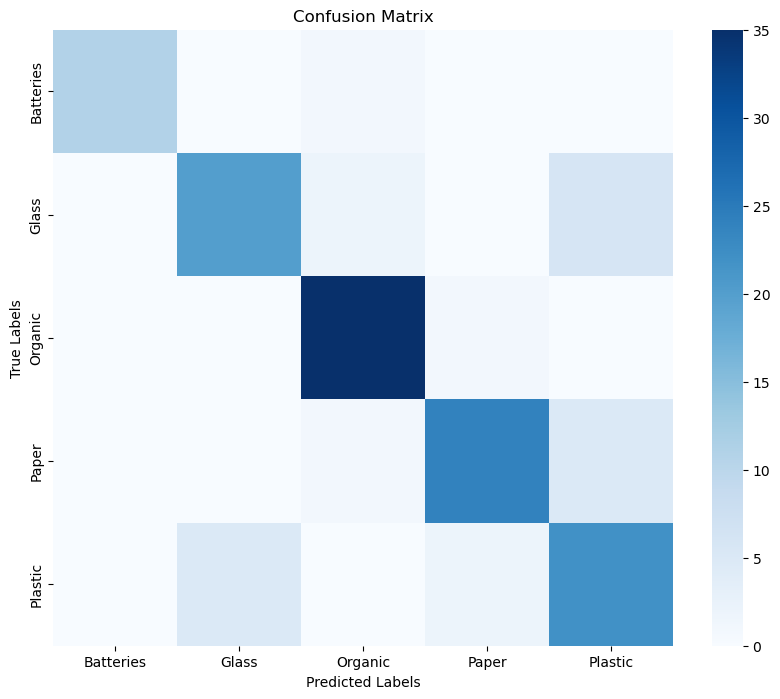

Student Model Validation Accuracy: 82.96%


In [133]:
# VAL ACCURACY COMPARISON

# TEACHER MODEL
teacher = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
teacher.classifier = nn.Sequential(
    nn.Dropout(0.4),  
    nn.Linear(teacher.classifier[1].in_features, 5)
)
teacher.load_state_dict(torch.load(r'FinalTeacher.pth', weights_only=True))
teacher = teacher.to(device)

# STUDENT MODEL
student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
student.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(student.classifier[1].in_features, 5)
)
student.load_state_dict(torch.load('FinalStudent.pth', weights_only=True))
student = student.to(device)

teacher.eval()
student.eval()


def evaluate_model(model, loader):
   
   
    test_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  
        for images, labels in val_custom_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            
            # Collect predictions and labels for the confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Plot the first batch of images in the validation set
            if total >= len(val_custom_loader.dataset):
                num_samples = min(8, len(images)) 
                plt.figure(figsize=(12, 6))
                for i in range(num_samples):
                    plt.subplot(2, 4, i + 1)
                    image_np = images[i].cpu().permute(1, 2, 0).numpy().clip(0, 1)
                    plt.imshow(image_np)
                    plt.title(f"True: {custom_dataset.classes[labels[i].item()]}\nPred: {custom_dataset.classes[predicted[i].item()]}")
                    plt.axis("off")

                plt.show()

        # Compute the average test loss and accuracy
        test_loss /= len(val_custom_loader)
        test_accuracy = 100 * correct / total

        # CM

        cm = confusion_matrix(all_labels, all_predictions)

        num_classes = len(custom_dataset.classes)
        class_names = custom_dataset.classes

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()
        

    return test_accuracy

print(f"Teacher Model Validation Accuracy: {evaluate_model(teacher, val_custom_loader):.2f}%")  
print(f"Student Model Validation Accuracy: {evaluate_model(student, val_custom_loader):.2f}%")

In [48]:
# Commparing weigh of the models

import os

teacher_size = os.path.getsize('FinalTeacher.pth') / 1e6
student_size = os.path.getsize('FinalStudent.pth') / 1e6

print(f"Teacher Model Size: {teacher_size:.2f} MB")
print(f"Student Model Size: {student_size:.2f} MB")

Teacher Model Size: 16.36 MB
Student Model Size: 9.17 MB


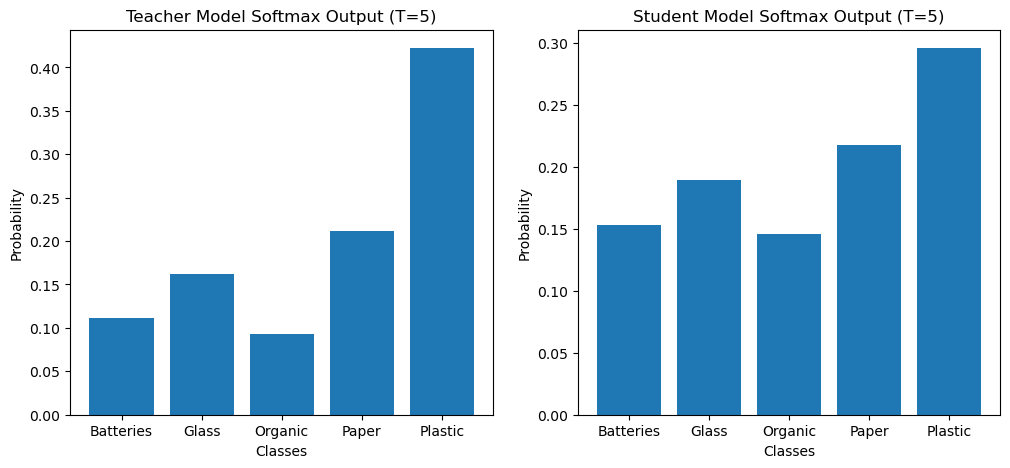

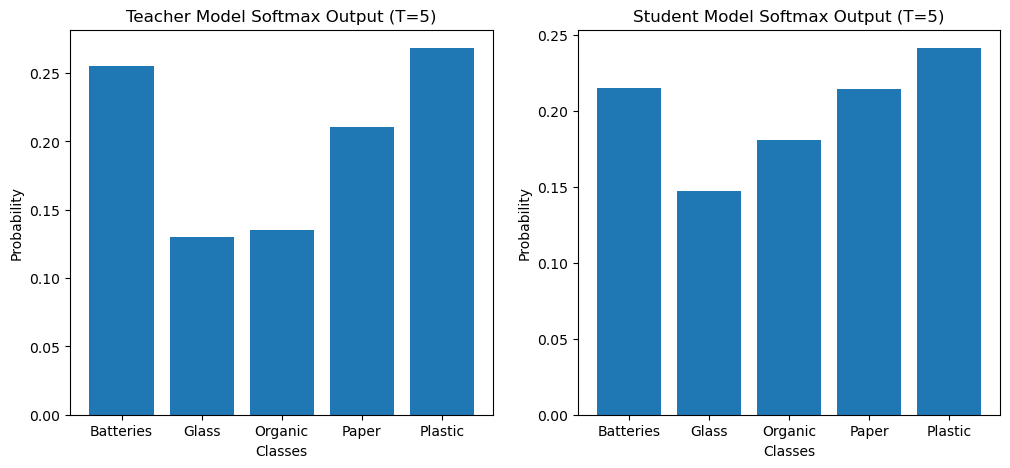

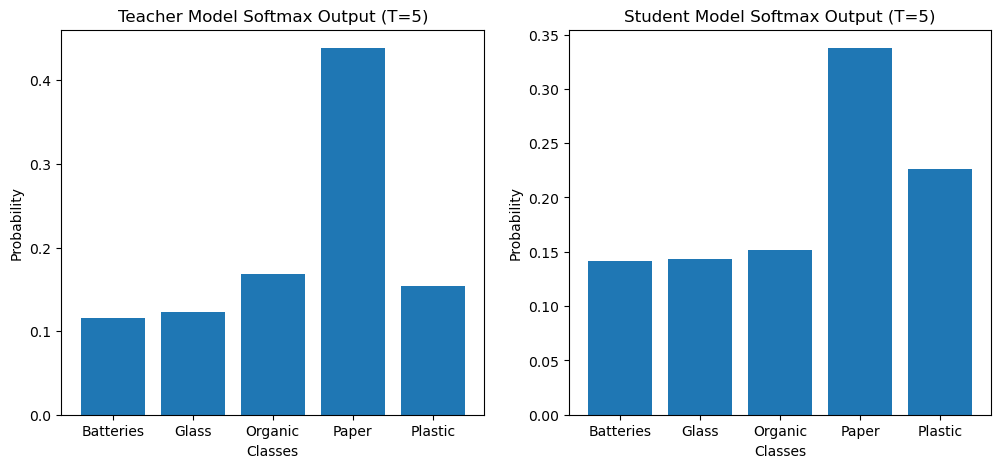

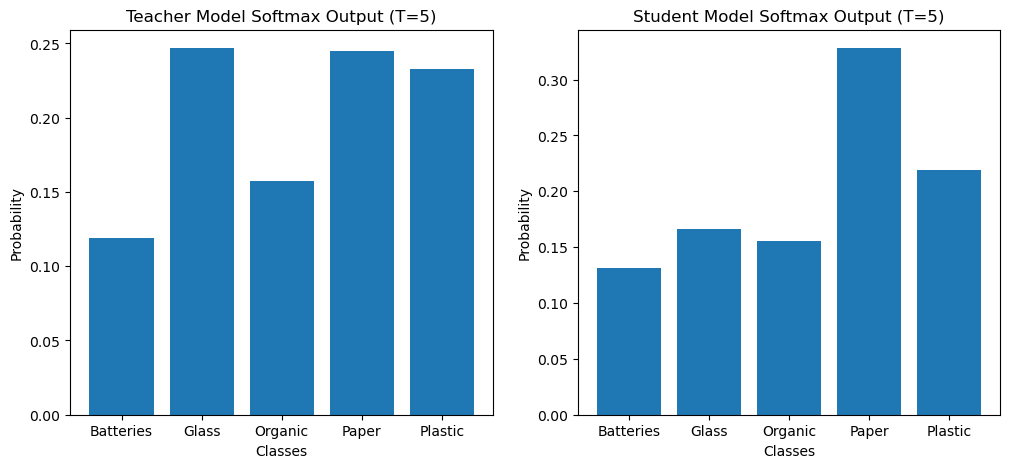

In [49]:
# For random imageg see softmax output with T

import os
from PIL import Image

folder = "testing_images"

img_files = os.listdir(folder)

for img_file in img_files:

    img_path = os.path.join(folder, img_file)

    # Load and preprocess the image
    image = Image.open(img_path).convert("RGB")

    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = data_transform(image).unsqueeze(0)
    input_tensor = image_tensor.to(device)

    # Make a prediction
    with torch.no_grad():
        teacher_output = teacher(input_tensor)
        student_output = student(input_tensor)

    # Compute the softmax outputs with temperature T=5
    T = 5

    teacher_probs = F.softmax(teacher_output / T, dim=1)
    student_probs = F.softmax(student_output / T, dim=1)


    # Plot the softmax outputs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(custom_dataset.classes, teacher_probs.squeeze().cpu().numpy())
    plt.title("Teacher Model Softmax Output (T=5)")
    plt.xlabel("Classes")
    plt.ylabel("Probability")

    plt.subplot(1, 2, 2)
    plt.bar(custom_dataset.classes, student_probs.squeeze().cpu().numpy())
    plt.title("Student Model Softmax Output (T=5)")
    plt.xlabel("Classes")
    plt.ylabel("Probability")

    plt.show()

    

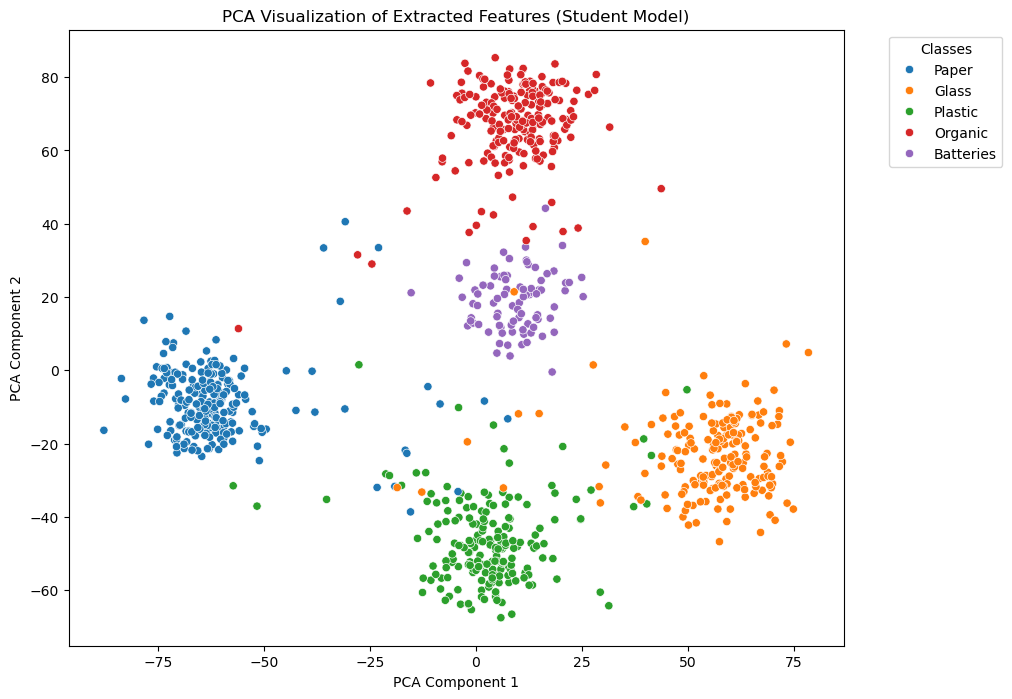

In [50]:
import torch
from sklearn.decomposition import PCA  # Import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the model to evaluation mode
student.eval()

# Lists to store extracted features and their corresponding labels
features = []
labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for loader in [train_custom_loader, val_custom_loader]:
        for images, lbls in loader:
            images = images.to(device)
            lbls = lbls.to(device)
            
            # Forward pass until the layer before classification to extract features
            outputs = student.features(images)  # Change this depending on the model architecture
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features if needed

            features.append(outputs.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

# Concatenate all features and labels into single arrays
features = np.concatenate(features, axis=0)
labels = np.array(labels)

# Reduce dimensions using PCA
pca = PCA(n_components=2, random_state=42)
features_2d = pca.fit_transform(features)

# Plot the PCA features
labels = [custom_dataset.classes[label] for label in labels]

plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette="tab10")
plt.title("PCA Visualization of Extracted Features (Student Model)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


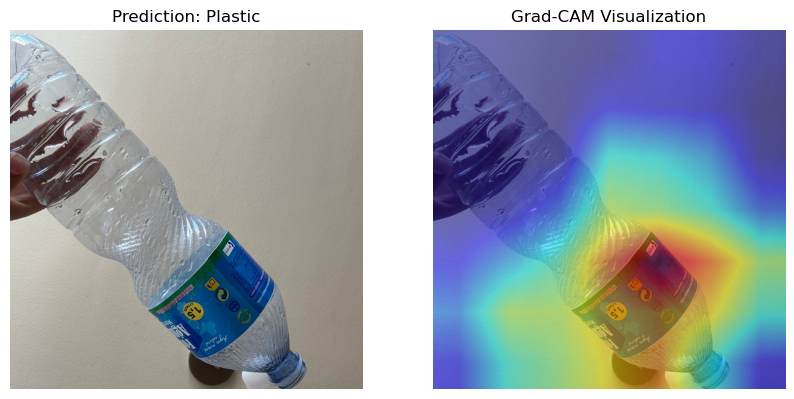

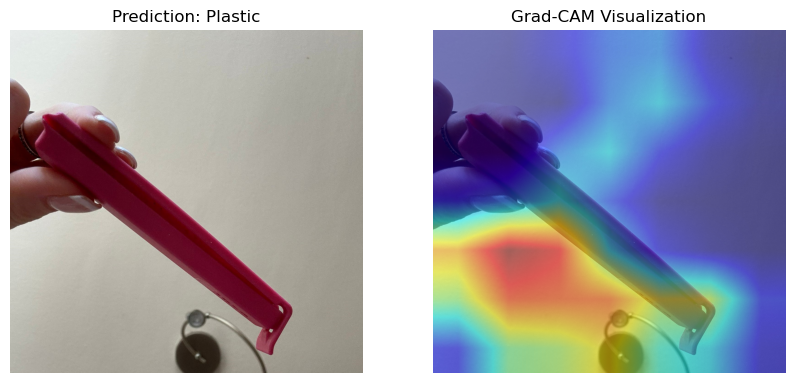

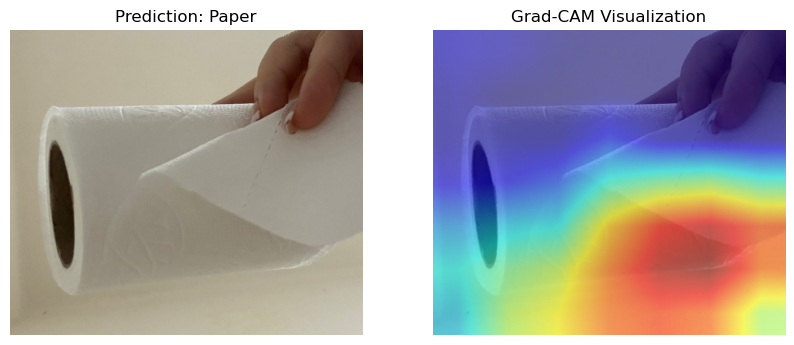

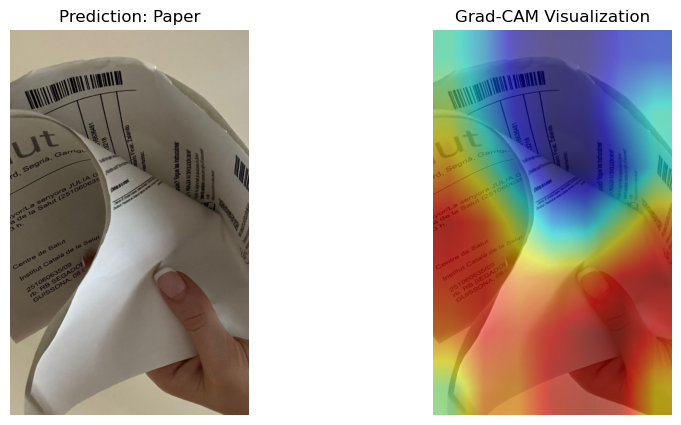

In [52]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
from torchvision import models, transforms
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt

IMG_SIZE = 224
# Inference of an image

import os
from PIL import Image
import torch
import torch.nn as nn

student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
student.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(student.classifier[1].in_features, 5)
)

student.load_state_dict(torch.load(r'FinalStudent.pth', weights_only=True))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student = student.to(device)

folder = "testing_images"
img_files = os.listdir(folder)

student.eval()

pred2class = {'Batteries': 0, 'Glass': 1, 'Organic': 2, 'Paper': 3, 'Plastic': 4}
class2pred = {v: k for k, v in pred2class.items()}

for img_file in img_files:
    img_path = os.path.join(folder, img_file)

    # Load and preprocess the image
    image = Image.open(img_path).convert("RGB")

    data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = data_transform(image).unsqueeze(0)
    input_tensor = image_tensor.to(device)

    # Make a prediction
    with torch.no_grad():
        output = student(input_tensor)
        _, prediction = torch.max(output, 1)

    # print(f"Prediction: {custom_dataset.classes[prediction.item()]}")

    # Choose the last convolutional layer
    target_layers = [student.features[-1]]

    # Use Grad-CAM or any other CAM method
    with GradCAM(model=student, target_layers=target_layers) as cam:

        targets = [ClassifierOutputTarget(prediction.item())]  
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        # Convert grayscale CAM to an overlay on the original image
        rgb_img = np.array(image) / 255.0
        grayscale_cam_resized = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))
        visualization = show_cam_on_image(rgb_img, grayscale_cam_resized, use_rgb=True)

        # Plot both the input image and the Grad-CAM visualization side by side
        plt.figure(figsize=(10, 5))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(rgb_img)
        plt.title("Prediction: " + class2pred[prediction.item()])
        #plt.title("Prediction: " + custom_dataset.classes[prediction.item()])
        plt.axis("off")
        
        # Grad-CAM visualization
        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title("Grad-CAM Visualization")
        plt.axis("off")
        
        
        plt.show()


In [ ]:
import torch

student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
student.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(student.classifier[1].in_features, 5)
)
student.load_state_dict(torch.load('FinalStudent.pth'))
torch.save(student.state_dict(), 'FinalStudent_CompatibleWithRaspberryPi.pth', _use_new_zipfile_serialization=False) # Compatibility with older PyTorch versions


### Experiment 1: Smaller Student

In this experiment, we aim to create a smaller and faster student model by applying pruning and/or quantization directly to the `student` model. Our objective is to optimize the model for reduced size and improved inference speed while maintaining acceptable performance.

In [69]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import time
from torchvision import models
import torch.nn as nn
import torch.quantization as quant

In [107]:
student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
student.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(student.classifier[1].in_features, 5)
)
student.load_state_dict(torch.load('FinalStudent.pth', weights_only=True))

quantized_student = torch.quantization.quantize_dynamic(
    student, {torch.nn.Linear}, dtype=torch.qint8
)

photo_path = r'C:\Users\User\OneDrive\Escritorio\AI Garbage Classification\AutoRecycle\testing_images\WhatsApp Image 2024-11-11 at 10.41.52 (1).jpeg'

data_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(), 
    ])

photo = Image.open(photo_path)
input_tensor = data_transform(photo).unsqueeze(0)


def measure_inference_time(model, input_tensor, iterations=200):
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        for _ in range(iterations):
            _ = model(input_tensor)
        end_time = time.time()
    avg_time = (end_time - start_time) / iterations
    return avg_time

original_time = measure_inference_time(student, input_tensor)
quantized_time = measure_inference_time(quantized_student, input_tensor)

print(f"Average Inference Time - Original Model: {original_time:.6f} seconds")
print(f"Average Inference Time - Quantized Model: {quantized_time:.6f} seconds")

Average Inference Time - Original Model: 0.023542 seconds
Average Inference Time - Quantized Model: 0.023359 seconds


In [82]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils import prune
import os

for module in student.modules():
    if isinstance(module, nn.Conv2d):
        prune.l1_unstructured(module, name="weight", amount=0.5)  # Prune 50% of weights

for module in student.modules():
    if isinstance(module, nn.Conv2d):
        prune.remove(module, "weight")


torch.save(student.state_dict(), "pruned_student.pth")

original_size = os.path.getsize("FinalStudent.pth")
pruned_size = os.path.getsize("pruned_student.pth")

print(f"Original Model Size: {original_size / 1e6:.2f} MB")
print(f"Pruned Model Size: {pruned_size / 1e6:.2f} MB")


Original Model Size: 9.17 MB
Pruned Model Size: 9.17 MB


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import time

student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
student.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(student.classifier[1].in_features, 5)
)
student.load_state_dict(torch.load('FinalStudent.pth', weights_only=True))

pruned_student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
pruned_student.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(pruned_student.classifier[1].in_features, 5)
)
pruned_student.load_state_dict(torch.load('pruned_student.pth', weights_only=True))

student.eval()
pruned_student.eval()

input_tensor = torch.randn(1, 3, 224, 224)

original_inference_times = []
for _ in range(100):
    start_time = time.time()
    _ = student(input_tensor)
    original_inference_times.append(time.time() - start_time)

pruned_inference_times = []
for _ in range(100):
    start_time = time.time()
    _ = pruned_student(input_tensor)
    pruned_inference_times.append(time.time() - start_time)


avg_original_time = sum(original_inference_times) / len(original_inference_times)
avg_pruned_time = sum(pruned_inference_times) / len(pruned_inference_times)

print(f"Average Inference Time - Original Model: {avg_original_time:.6f} seconds")
print(f"Average Inference Time - Pruned Model: {avg_pruned_time:.6f} seconds")


Average Inference Time - Original Model: 0.028627 seconds
Average Inference Time - Pruned Model: 0.028441 seconds


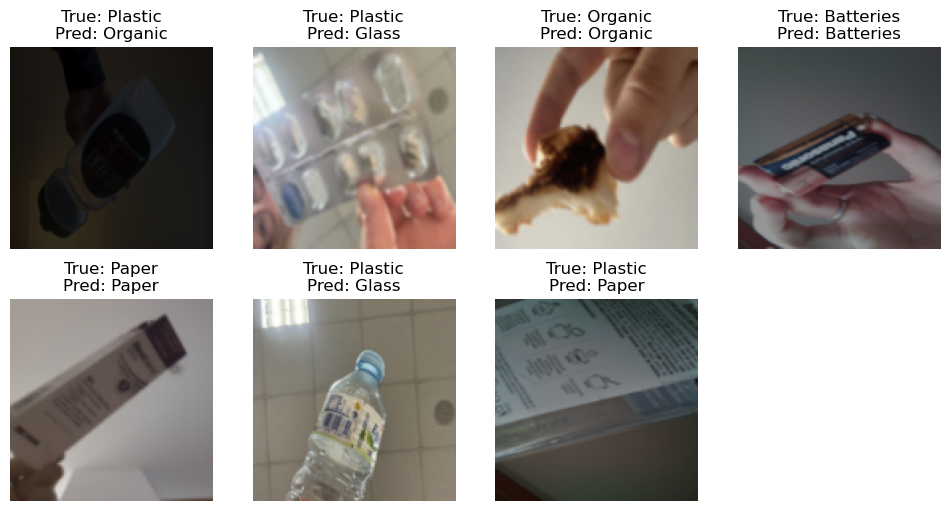

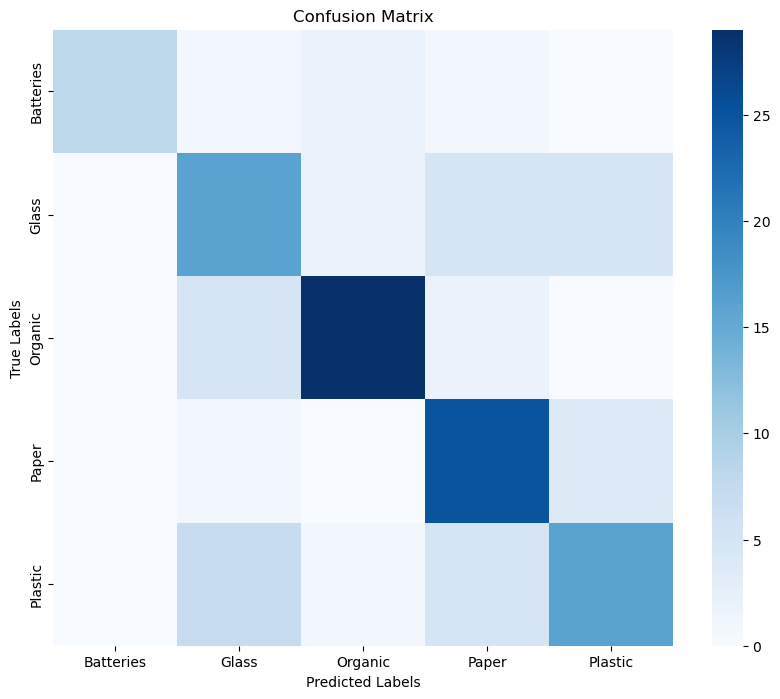

Pruned Student Model Validation Accuracy: 69.63%


In [87]:
print(f"Pruned Student Model Validation Accuracy: {evaluate_model(pruned_student.to(device), val_custom_loader):.2f}%")  

**Conclusion**: The `student` model is already a lightweight architecture, so the computational savings from pruning and quantization are negligible. Additionally, the accuracy drops significantly by 15%, resulting in a final accuracy of 70%. This tradeoff makes pruning suboptimal for this model, as the performance loss outweighs the minimal gains in efficiency.

### Experiment 2: Smaller Teacher

The goal of this experiment is to create a smaller, efficient student model by applying pruning and quantization directly to the teacher model, instead of working on the original student model. Then, compare the results with the student obtained after the knowledge distillation process.

In [131]:
import torch
import torch.nn as nn
from torch.nn.utils import prune
import torchvision.models as models
from torchvision.models.efficientnet import EfficientNet_B0_Weights

teacher = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
teacher.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(teacher.classifier[1].in_features, 5)
)
teacher.load_state_dict(torch.load('FinalTeacher.pth', weights_only=True))

def prune_model(model, amount=0.2):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')  

prune_model(teacher, amount=0.4)

torch.save(teacher.state_dict(), 'PrunedTeacher.pth')

print("Pruned model saved successfully!")

Pruned model saved successfully!


In [125]:
teacher_quantized = torch.quantization.quantize_dynamic(
    teacher, {nn.Linear}, dtype=torch.qint8  
)
torch.save(teacher_quantized.state_dict(), 'QuantizedPrunedTeacher.pth')

In [126]:
teacher = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
teacher.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(teacher.classifier[1].in_features, 5)
)
teacher.load_state_dict(torch.load('FinalTeacher.pth', weights_only=True))

teacher.eval()
teacher_quantized.eval()

input_tensor = torch.randn(1, 3, 224, 224)

original_inference_times = []
for _ in range(100):
    start_time = time.time()
    _ = teacher(input_tensor)
    original_inference_times.append(time.time() - start_time)

quantized_inference_times = []
for _ in range(100):
    start_time = time.time()
    _ = teacher_quantized(input_tensor)
    quantized_inference_times.append(time.time() - start_time)

avg_original_time = sum(original_inference_times) / len(original_inference_times)
avg_quantized_time = sum(quantized_inference_times) / len(quantized_inference_times)

# Print results
print(f"Average Inference Time - Original Teacher Model: {avg_original_time:.6f} seconds")
print(f"Average Inference Time - Quantized Pruned Teacher Model: {avg_quantized_time:.6f} seconds")

print("\n")
print(f"Original Teacher Model Size: {os.path.getsize('FinalTeacher.pth') / 1e6:.2f} MB")
print(f"Pruned and Quantized Teacher Model Size: {os.path.getsize('QuantizedPrunedTeacher.pth') / 1e6:.2f} MB")


Average Inference Time - Original Teacher Model: 0.045397 seconds
Average Inference Time - Quantized Pruned Teacher Model: 0.034556 seconds


Original Teacher Model Size: 16.36 MB
Pruned and Quantized Teacher Model Size: 16.34 MB


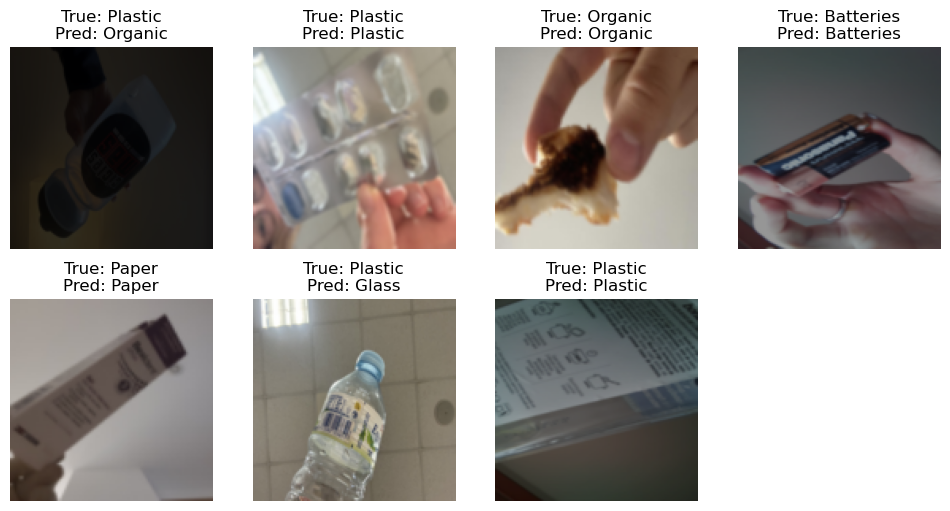

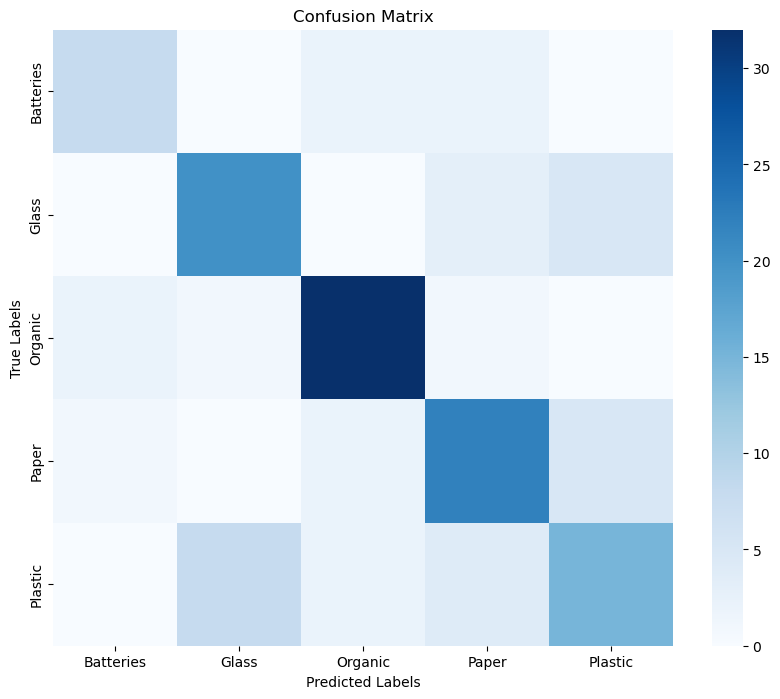

Pruned Teacher Validation Accuracy: 71.85%


In [132]:

print(f"Pruned Teacher Validation Accuracy: {evaluate_model(teacher.to(device), val_custom_loader):.2f}%")